In [46]:
import xarray as xr
import numpy as np
from numpy.polynomial import polynomial
import matplotlib.pyplot as plt
from utils import detrend_members
import os

import dask
print('...setting up dask client...')
if 'client' in locals():
    client.shutdown()
    print('...shutdown client...')
else:
    print('client does not exist yet')
# ### ++++++ dask NCAR client: 
from distributed import Client
from dask_jobqueue import PBSCluster
dask.config.set(**{'array.slicing.split_large_chunks': False}) #supress warning about large chunk

...setting up dask client...


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


...shutdown client...


In [10]:
#Setup your PBSCluster
cluster = PBSCluster(
                    cores=1, 
                    memory='10GB', # Amount of memory
                    #processes=1, 
                    queue='casper', 
                    shared_temp_directory='/glade/derecho/scratch/kjmayer/tmp', # Use your local directory
                    #resource_spec='select=1:ncpus=1:mem=10GB', 
                    project='P06010014', 
                    walltime='08:00:00'
                    )

# Scale up
cluster.scale(10)

client = Client(cluster)
client

/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kjmayer/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kjmayer/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.75:39663,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kjmayer/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
# client.shutdown()

In [2]:
atm_dir = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/'
# Y = 'TREFHT'

atm0 = 'TREFHT'
# atm1 = 'U100'
# atm2 = 'Z500'

ocn = 'TS' #need land mask

lnd_dir = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/day_1/'
lnd = 'SOILWATER_10CM'

ens_strt = '1231' # max
# ens_strt = '1251' # decreasing
# ens_strt = '1281' # min
# ens_strt = '1301' # increasing
ens = ['011','012','013','014','015','016','017','018','019','020']

savepath = '/glade/derecho/scratch/kjmayer/DATA/CESM2-LE/HIST/'

## Load raw CESM data & convert to 1950-2014 & [time,lat::2,lon::2]

In [16]:
# TREFHT
if not os.path.exists(savepath+atm0):
    os.makedirs(savepath+atm0)
    
for e in range(len(ens)):
    atm0_savefi   = atm0+'_'+ens[e]+'_1950-2014.nc'
    if not os.path.exists(savepath+atm0+'/'+atm0_savefi):
        print(ens[e])
        atm0_fi = 'b.e21.BHISTsmbb.f09_g17.LE2-'+ens_strt+'.'+ens[e]+'.cam.h1.'+atm0+'.*.nc' 
        atm0_ens = xr.open_mfdataset(atm_dir+atm0+'/'+atm0_fi,
                                     concat_dim = 'time',
                                     combine="nested",
                                     preprocess = lambda ds: ds[atm0].where((ds[atm0].time.dt.year >= 1950) &
                                                                            (ds[atm0].time.dt.year <= 2014),
                                                                            drop = True)[:,::2,::2]
                                    )
        atm0_ens.to_netcdf(savepath+atm0+'/'+atm0_savefi)
        del(atm0_ens)

012
013
014
015
016
017
018
019
020


In [5]:
# SOILWATER_10CM
if not os.path.exists(savepath+lnd):
    os.makedirs(savepath+lnd)
    print('made directory: '+savepath+lnd)
    
for e in range(len(ens)):
    lnd_savefi   = lnd+'_'+ens[e]+'_1950-2014.nc'
    if not os.path.exists(savepath+lnd+'/'+lnd_savefi):
        print(ens[e])
        lnd_fi = 'b.e21.BHISTsmbb.f09_g17.LE2-'+ens_strt+'.'+ens[e]+'.clm2.h5.'+lnd+'.*.nc' 
        lnd_ens = xr.open_mfdataset(lnd_dir+lnd+'/'+lnd_fi,
                                     concat_dim = 'time',
                                     combine="nested",
                                     preprocess = lambda ds: ds[lnd].where((ds[lnd].time.dt.year >= 1950) &
                                                                            (ds[lnd].time.dt.year <= 2014),
                                                                            drop = True)[:,::2,::2]
                                    )
        lnd_ens.to_netcdf(savepath+lnd+'/'+lnd_savefi)
        del(lnd_ens)

019
020


In [6]:
path = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/SST/'
finame = 'b.e21.BHISTsmbb.f09_g17.LE2-1231.011.cam.h0.SST.185001-185912.nc'
SST_mask = xr.open_dataset(path+finame)['SST'][0,::2,::2]
SST_mask = xr.where(SST_mask==0,x=0,y=1)

# Skin Temp ("SST")
if not os.path.exists(savepath+ocn):
    os.makedirs(savepath+ocn)
    print('made directory: '+savepath+ocn)
    
for e in range(len(ens)):
    ocn_savefi = ocn+'_'+ens[e]+'_1950-2014.nc'
    if not os.path.exists(savepath+ocn+'/'+ocn_savefi):
        print(ens[e])
        ocn_fi = 'b.e21.BHISTsmbb.f09_g17.LE2-'+ens_strt+'.'+ens[e]+'.cam.h1.'+ocn+'.*.nc' 
        ocn_ens = xr.open_mfdataset(atm_dir+ocn+'/'+ocn_fi,
                                     concat_dim = 'time',
                                     combine="nested",
                                     preprocess = lambda ds: ds[ocn].where((ds[ocn].time.dt.year >= 1950) &
                                                                            (ds[ocn].time.dt.year <= 2014),
                                                                            drop = True)[:,::2,::2]
                                    )
        #     ocn_ens[0].plot(vmin=240,vmax=300)
        #     plt.show()
        ocn_ens = ocn_ens*SST_mask
        #     ocn_ens[0].plot(vmin=240,vmax=300)
        #     plt.show()
        
        ocn_ens.to_netcdf(savepath+ocn+'/'+ocn_savefi)
        del(ocn_ens)

made directory: /glade/derecho/scratch/kjmayer/DATA/CESM2-LE/HIST/TS
011


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 11.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


012


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 11.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


013


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 11.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


014


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 11.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


015


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 11.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


016


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 11.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


017


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 11.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


018


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 11.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


019


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 11.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


020


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 11.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## Forcing

In [7]:
atm0_ens_finame = atm0+'_*_1950-2014.nc'

atm0_allens = xr.open_mfdataset(savepath+atm0+'/'+atm0_ens_finame,
                              concat_dim = 'ens',
                              combine="nested",
                              )[atm0]

chunk_dict = {"ens": 1, "time":23725, "lat": 24, "lon": 36}
atm0_allens = atm0_allens.chunk(chunk_dict)

atm0_allens = atm0_allens.compute()


atm0_ensmean = atm0_allens.mean('ens')
chunk_dict = {"time":23725, "lat": 24, "lon": 36}
atm0_ensmean = atm0_ensmean.chunk(chunk_dict)

atm0_ensmean = atm0_ensmean.compute()

# ----- SAVE INPUT ----
atm0_ensmean.to_netcdf(savepath+atm0+'/'+atm0+'_ensmean011-020_1950-2014.nc')

/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 1.22 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


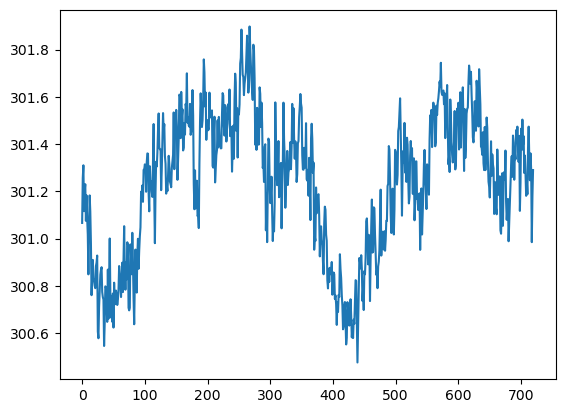

In [8]:
plt.plot(atm0_ensmean[:720,50,50])

In [9]:
lnd_ens_finame = lnd+'_*_1950-2014.nc'

lnd_allens = xr.open_mfdataset(savepath+lnd+'/'+lnd_ens_finame,
                              concat_dim = 'ens',
                              combine="nested",
                              )[lnd]

chunk_dict = {"ens": 1, "time":23725, "lat": 24, "lon": 36}
lnd_allens = lnd_allens.chunk(chunk_dict)

lnd_allens = lnd_allens.compute()


lnd_ensmean = lnd_allens.mean('ens')
chunk_dict = {"time":23725, "lat": 24, "lon": 36}
lnd_ensmean = lnd_ensmean.chunk(chunk_dict)

lnd_ensmean = lnd_ensmean.compute()

# ----- SAVE INPUT ----
lnd_ensmean.to_netcdf(savepath+lnd+'/'+lnd+'_ensmean011-020_1950-2014.nc')

/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 1.22 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


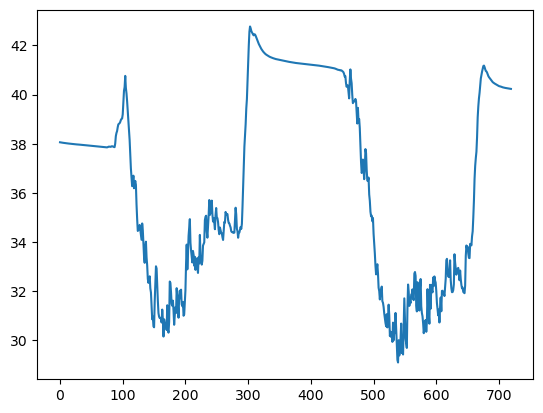

In [30]:
plt.plot(lnd_ensmean[:720,75,50])

In [16]:
ocn_ens_finame = ocn+'_*_1950-2014.nc'

ocn_allens = xr.open_mfdataset(savepath+ocn+'/'+ocn_ens_finame,
                              concat_dim = 'ens',
                              combine="nested",
                              )['__xarray_dataarray_variable__']

chunk_dict = {"ens": 1, "time":23725, "lat": 24, "lon": 36}
ocn_allens = ocn_allens.chunk(chunk_dict)
print('compute chunking')
ocn_allens = ocn_allens.compute()


ocn_ensmean = ocn_allens.mean('ens')
chunk_dict = {"time":23725, "lat": 24, "lon": 36}
ocn_ensmean = ocn_ensmean.chunk(chunk_dict)
print('compute mean & chunk')
ocn_ensmean = ocn_ensmean.compute()

# ----- SAVE INPUT ----
print('save climo')
ocn_ensmean.to_netcdf(savepath+ocn+'/'+ocn+'_ensmean011-020_1950-2014.nc')

compute chunking
compute mean & chunk


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.44 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


save climo


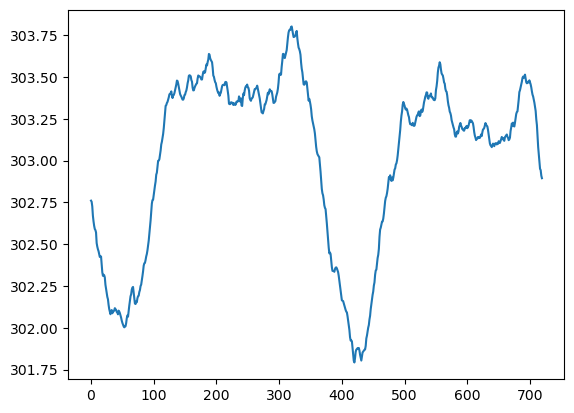

In [17]:
plt.plot(ocn_ensmean[:720,50,50])

## SeasonalCycle/Climo

In [18]:
atmforce = xr.open_dataarray(savepath+atm0+'/'+atm0+'_ensmean011-020_1950-2014.nc')
lndforce = xr.open_dataarray(savepath+lnd+'/'+lnd+'_ensmean011-020_1950-2014.nc')
ocnforce = xr.open_dataarray(savepath+ocn+'/'+ocn+'_ensmean011-020_1950-2014.nc')

In [19]:
atmclimo = atmforce.groupby('time.dayofyear').mean()

In [20]:
lndclimo = lndforce.groupby('time.dayofyear').mean()

In [21]:
ocnclimo = ocnforce.groupby('time.dayofyear').mean()

In [22]:
atmclimo.to_netcdf(savepath+atm0+'/'+atm0+'_doymean_ensmean011-020_1950-2014.nc')
print('atm saved')
lndclimo.to_netcdf(savepath+lnd+'/'+lnd+'_doymean_ensmean011-020_1950-2014.nc')
print('lnd saved')
ocnclimo.to_netcdf(savepath+ocn+'/'+ocn+'_doymean_ensmean011-020_1950-2014.nc')
print('ocn saved')

atm saved
lnd saved
ocn saved


## Remove Seasonal Cycle & Detrend Output:

In [29]:
atm0_ensmean = xr.open_dataarray(savepath+atm0+'/'+atm0+'_ensmean011-020_1950-2014.nc')
lnd_ensmean = xr.open_dataarray(savepath+lnd+'/'+lnd+'_ensmean011-020_1950-2014.nc')
lnd_ensmean_nonan = lnd_ensmean.fillna(-999)
ocn_ensmean = xr.open_dataarray(savepath+ocn+'/'+ocn+'_ensmean011-020_1950-2014.nc')

In [13]:
atm0_ens_finame = atm0+'_0*_1950-2014.nc'
atm0_allens = xr.open_mfdataset(savepath+atm0+'/'+atm0_ens_finame,
                              concat_dim = 'ens',
                              combine="nested",
                              )[atm0]

/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


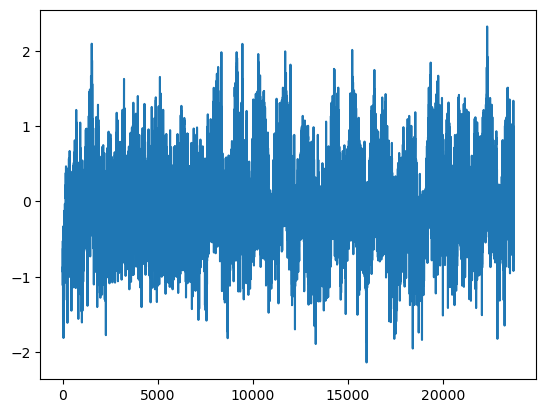

CPU times: user 32.5 s, sys: 5.65 s, total: 38.1 s
Wall time: 49.9 s


In [14]:
%%time
atm0_detrended = detrend_members(data = atm0_allens, 
                                 ensmean_data = atm0_ensmean, 
                                 npoly = 3)

plt.plot(atm0_detrended[0,:,50,50])
# plt.plot(atm0_allens[0,:500,50,50])
plt.show()

In [15]:
%%time
ens = ['011','012','013','014','015','016','017','018','019','020']
for e in range(len(ens)):
    print(ens[e])
    atm0_detrended[e].to_netcdf(savepath+atm0+'/'+atm0+'_anom_'+ens[e]+'_1950-2014.nc')

011


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


012


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


013


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


014


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


015


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


016


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


017


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


018


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


019


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


020


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3min 14s, sys: 33.1 s, total: 3min 47s
Wall time: 7min 50s


In [26]:
lnd_ens_finame = lnd+'_0*_1950-2014.nc'
lnd_allens = xr.open_mfdataset(savepath+lnd+'/'+lnd_ens_finame,
                              concat_dim = 'ens',
                              combine="nested",
                              )[lnd]

lnd_allens_nonan = lnd_allens.fillna(-999)

/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


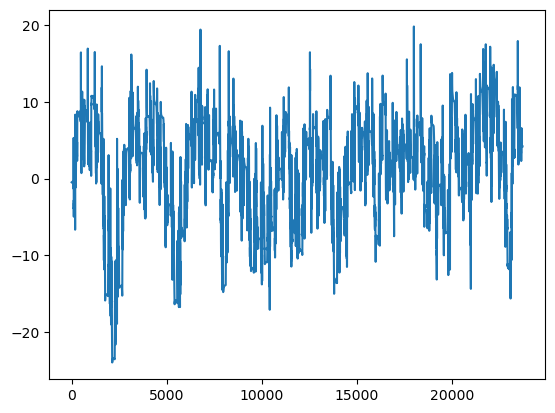

CPU times: user 33.4 s, sys: 6.59 s, total: 40 s
Wall time: 45.4 s


In [31]:
%%time
lnd_detrended = detrend_members(data = lnd_allens_nonan, 
                                ensmean_data = lnd_ensmean_nonan, 
                                npoly = 3)

plt.plot(lnd_detrended[0,:,75,50])
# plt.plot(lnd_allens[0,:500,75,50])
plt.show()

In [32]:
%%time
ens = ['011','012','013','014','015','016','017','018','019','020']
for e in range(len(ens)):
    print(ens[e])
    lnd_detrended[e].to_netcdf(savepath+lnd+'/'+lnd+'_anom_'+ens[e]+'_1950-2014.nc')

011


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


012


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


013


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


014


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


015


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


016


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


017


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


018


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


019


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


020


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3min 22s, sys: 43.3 s, total: 4min 5s
Wall time: 8min 24s


In [34]:
ocn_ens_finame = ocn+'_0*_1950-2014.nc'
ocn_allens = xr.open_mfdataset(savepath+ocn+'/'+ocn_ens_finame,
                              concat_dim = 'ens',
                              combine="nested",
                              )['__xarray_dataarray_variable__']

/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


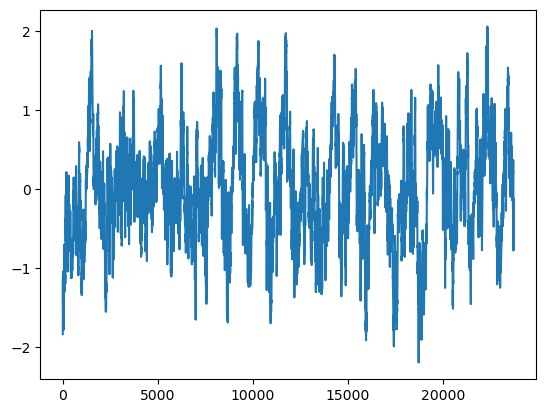

CPU times: user 34.4 s, sys: 6.61 s, total: 41 s
Wall time: 46.6 s


In [44]:
%%time
ocn_detrended = detrend_members(data = ocn_allens, 
                                 ensmean_data = ocn_ensmean, 
                                 npoly = 3)

plt.plot(ocn_detrended[0,:,50,50])
# plt.plot(ocn_allens[0,:500,50,50])
plt.show()

In [45]:
%%time
ens = ['011','012','013','014','015','016','017','018','019','020']
for e in range(len(ens)):
    print(ens[e])
    ocn_detrended[e].to_netcdf(savepath+ocn+'/'+ocn+'_anom_'+ens[e]+'_1950-2014.nc')

011


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


012


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


013


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


014


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


015


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


016


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


017


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


018


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


019


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


020


/glade/work/kjmayer/conda-envs/ViT_XAI/lib/python3.11/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 2.45 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3min 30s, sys: 1min 1s, total: 4min 31s
Wall time: 9min 7s
